Imports

In [1]:
from orbit_generation_testing.reader import *
from orbit_generation_testing.processing import *

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


2024-04-25 21:59:26.202404: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-25 21:59:26.225156: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 21:59:26.225176: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 21:59:26.225726: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-25 21:59:26.229338: I tensorflow/core/platform/cpu_feature_guar

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
from tensorflow import keras
import tsgm

2024-04-25 21:59:29.083487: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-25 21:59:29.083602: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-25 21:59:29.083682: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Data

## Imports

In [4]:
data_path = r"/workspace/data/em_orbits.h5"

In [13]:
data_path = r"C:\Users\alvar\Documents\GitHub\orbit-generation-testing\data\orbit_data_by_period.h5"

In [5]:
data = load_orbit_data(data_path, dataset_path='files/PERIODIC ORBITS')
data.shape

(36071, 7, 7500)

In [6]:
data = data[:, :, :1500]
data.shape

(36071, 7, 1500)

In [9]:
labels_path = r"/workspace/data/em_features.mat"

In [7]:
labels_path = r"C:\Users\alvar\Documents\GitHub\orbit-generation-testing\data\orbit_data_by_period_labels.npy"

In [10]:
labels= get_orbit_features(labels_path)
labels.head()

,Orbit Family,Initial Position X,Initial Position Y,Initial Position Z,Initial Velocity X,Initial Velocity Y,Initial Velocity Z,Jacobi Constant,Period,Stability Index
0,1.0,0.941000,1.900442e-23,0.509474,2.968938e-13,-0.124968,-3.122717e-12,2.745412,11.555291,211.184678
1,1.0,0.941538,-8.592698e-24,0.508602,2.902340e-13,-0.125672,-3.252212e-12,2.746226,11.551622,210.329145
2,1.0,0.942076,6.956604e-24,0.507729,2.685527e-13,-0.126375,-2.862050e-12,2.747039,11.547936,209.473685
3,1.0,0.942613,1.763946e-24,0.506856,3.153637e-13,-0.127078,-3.791054e-12,2.747850,11.544233,208.618315
4,1.0,0.943150,9.441804e-24,0.505982,2.663322e-13,-0.127781,-2.982720e-12,2.748660,11.540511,207.763051


In [ ]:
labels = labels['Orbit Family'].to_list()

In [20]:

labels[0:5]

[1.0, 1.0, 1.0, 1.0, 1.0]

## Selection and Interpolation (only for testing)

In [17]:
import numpy as np
import pandas as pd

np.random.seed(42)
indices = np.random.choice(data.shape[0], 64, replace=False)

# Select the data and labels using these indices
selected_data = data[indices]
selected_labels = labels[indices]

data = selected_data
labels = selected_labels



In [ ]:
np.save('test_data.npy',data)
np.save('test_labels.npy',labels)

In [3]:
data = np.load('test_data.npy')
labels = np.load('test_labels.npy')

In [11]:
data.shape

(36071, 7, 7500)

In [11]:
data = resample_3d_array(data=data, axis=2, target_size=300)

In [ ]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

## Transformation

In [12]:
transposed_orbits = np.transpose(data, (0, 2, 1))

In [13]:
scaler = tsgm.utils.TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(transposed_orbits)
scaled_data.shape

(36071, 300, 7)

batch,timestamps,scalars

# Generation

## Make GPU available

In [16]:
import platform
import os
import psutil
from tensorflow.python.client import device_lib

print(platform.system())
print(platform.release())

print("Number of CPUs:", os.cpu_count())
print("Total memory:", psutil.virtual_memory().total / (1024**3), "GB")

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print("Available GPUs:", get_available_gpus())

Linux
5.15.0-105-generic
Number of CPUs: 16
Total memory: 125.67595291137695 GB
Available GPUs: ['/device:GPU:0', '/device:GPU:1']


2024-04-25 21:54:24.855880: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-25 21:54:24.856024: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-25 21:54:24.856099: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Parameters

In [14]:
latent_dim = 32
feature_dim = 7
seq_len = 300 # CHECK!!!!
batch_size = 32
epochs = 10 # CHECK!!!!

## Define Architecture

In [15]:
architecture = tsgm.models.zoo["vae_conv5"](seq_len=seq_len, feat_dim=feature_dim, latent_dim=latent_dim)
encoder, decoder = architecture.encoder, architecture.decoder

## Fit

In [16]:
vae = tsgm.models.cvae.BetaVAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(scaled_data, epochs=epochs, batch_size=batch_size)

Epoch 1/10


2024-04-25 22:01:08.717391: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-04-25 22:01:09.549841: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f50497ca9a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-25 22:01:09.549861: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-04-25 22:01:09.549864: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-04-25 22:01:09.552607: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1714082469.597234   97875 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1128/1128 [==============================] - 68s 56ms/step - loss: 489.5458 - reconstruction_loss: 225.8887 - kl_loss: 20.3975
Epoch 2/10
1128/1128 [==============================] - 63s 56ms/step - loss: 75.1592 - reconstruction_loss: 49.8716 - kl_loss: 21.3859
Epoch 3/10
1128/1128 [==============================] - 63s 56ms/step - loss: 48.2486 - reconstruction_loss: 33.2782 - kl_loss: 19.0606
Epoch 4/10
1128/1128 [==============================] - 63s 56ms/step - loss: 40.7249 - reconstruction_loss: 20.5406 - kl_loss: 16.3190
Epoch 5/10
1128/1128 [==============================] - 64s 56ms/step - loss: 52.6496 - reconstruction_loss: 31.3042 - kl_loss: 16.8250
Epoch 6/10
1128/1128 [==============================] - 64s 56ms/step - loss: 30.5208 - reconstruction_loss: 14.5079 - kl_loss: 14.6133
Epoch 7/10
1128/1128 [==============================] - 64s 56ms/step - loss: 32.4352 - reconstruction_loss: 28.6962 - kl_loss: 15.7346
Epoch 8/10
1128/1128 [==============================] - 6

In [21]:
encoder.save('encoder_conv5_by_period', save_format='tf')
decoder.save('decoder_conv5_by_period', save_format='tf')

INFO:tensorflow:Assets written to: encoder_conv5_by_period/assets


INFO:tensorflow:Assets written to: encoder_conv5_by_period/assets


INFO:tensorflow:Assets written to: decoder_conv5_by_period/assets


INFO:tensorflow:Assets written to: decoder_conv5_by_period/assets


## Predict

In [22]:
x_decoded = vae.predict(scaled_data)

1128/1128 [==============================] - 16s 14ms/step


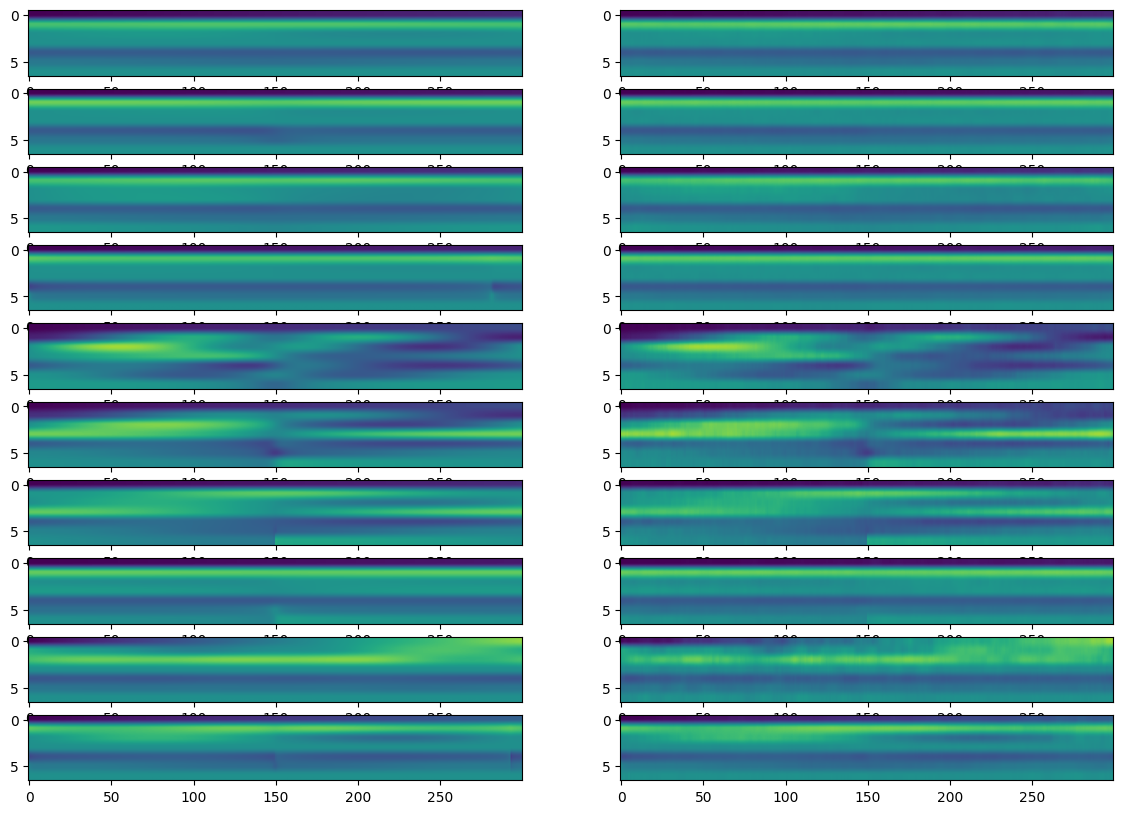

In [23]:
tsgm.utils.visualize_original_and_reconst_ts(scaled_data, x_decoded, num=10)

## Generate

In [24]:
generation = vae.generate(100)
generation.shape

TensorShape([10, 300, 7])

In [ ]:
np.save('/generation.npy', generation)

/tmp/ipykernel_97721/321560769.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', 30)


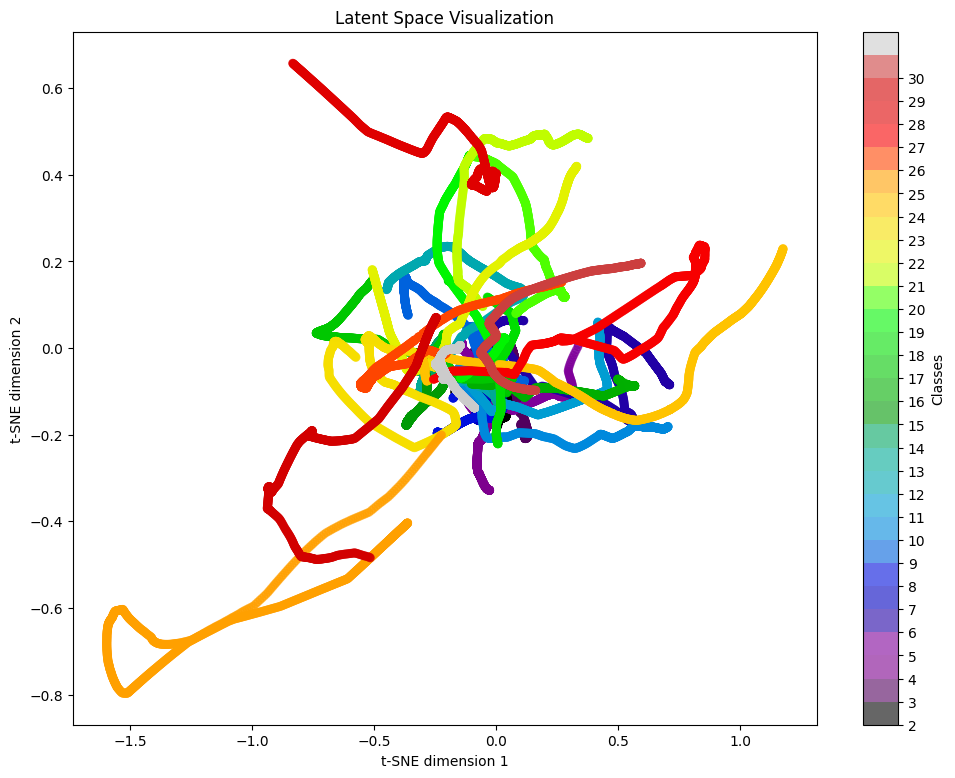

In [29]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Encode data into the latent space
latent_mean, _, _ = vae.encoder(scaled_data)
latent_representations = latent_mean.numpy()  # Convert tensor to numpy array

# Use t-SNE to reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(latent_representations)

# Create a new colormap with 30 unique colors
cmap = plt.cm.get_cmap('nipy_spectral', 30)

# Plot the t-SNE output with colors
plt.figure(figsize=(12, 9))
scatter = plt.scatter(latent_representations[:, 0], latent_representations[:, 1], alpha=0.6, c=labels, cmap=cmap, s=30)
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.title('Latent Space Visualization')

# Create a colorbar with the unique labels
colorbar = plt.colorbar(scatter, ticks=range(30))
colorbar.set_label('Classes')

# Set the colorbar to show the class labels
colorbar.set_ticklabels(range(1, 31))

plt.show()
